# **Disease Detection using Symptoms and Treatment recommendation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# importing nltk to download resources for stopwords and wordnet
import nltk
nltk.download('all')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 4.7 MB/s 


In [ ]:
# importing all libraries
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import top_k_accuracy_score
import math
import operator
import pickle
import re
#from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from statistics import mean
from nltk.corpus import wordnet 
import requests
from bs4 import BeautifulSoup
from itertools import combinations
from time import time
from collections import Counter
import operator
import warnings
import json
from google.colab import files
src = list(files.upload().values())[0]
#open('Treatment.py','wb').write(src)
from Treatment import diseaseDetail
uploaded = files.upload()
# ignore warnings generated due to usage of old version of tensorflow
warnings.simplefilter("ignore")

Saving Treatment.py to Treatment.py


Saving dict.json to dict.json


**Disease Symptom dataset** was created in a separate python program.

**Dataset scrapping** was done using **NHP website** and **wikipedia data**

In [ ]:
# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Scrapping and creation of dataset csv is done in a separate program
df=pd.read_excel("/content/drive/My Drive/MAGISTER ILMU KOMPUTER 2021/Group Stanford/Disease-Detection-based-on-Symptoms-master/Dataset/dis_sym_dataset_norm2.xlsx") # Individual Disease
documentname_list=list(df['label_dis'])
df=df.iloc[:,1:]
columns_name=list(df.columns)
documentname_list=list(documentname_list)

N=len(df)
M=len(columns_name) 

# All symptoms IDF
idf={}
for col in columns_name:
  temp=np.count_nonzero(df[col])
  idf[col]=np.log(N/temp)

# All disease,symptom TF
tf={}
for i in range(N):
  for col in columns_name:
    key=(documentname_list[i],col)
    tf[key]=df.loc[i,col]

# All disease,symptom TF.IDF
tf_idf={}
for i in range(N):
  for col in columns_name:
    key=(documentname_list[i],col) #key=(penyakit, gejala)
    tf_idf[key]=float(idf[col])*float(tf[key])

# vector of TF.IDF
D = np.zeros((N, M),dtype='float32')
for i in tf_idf:
    sym = columns_name.index(i[1])
    dis=documentname_list.index(i[0])
    D[dis][sym] = tf_idf[i]

def load(filename):	
	with open(filename) as data_file:
		data = json.load(data_file)	
  
	return data
  
# Data Synonims
mydict = load('dict.json')

def synonyms(word):
	if word in mydict.keys():
		return set(mydict[word]['sinonim'])
	else:
		return set([])

# function for cosine dot product
def cosine_dot(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    else:
        temp = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        return temp

# convert data to lower case
def convert_tolowercase(data):
    return data.lower()

# tokenizing using regextokenizer
def regextokenizer_func(data):
    tokenizer = RegexpTokenizer(r'\w+')
    data = tokenizer.tokenize(data)
    return data

# function to generate query vector for tf_idf
def gen_vector(tokens):
    Q = np.zeros(M)
    counter = Counter(tokens)
    query_weights = {}
    for token in np.unique(tokens):
        tf = counter[token]
        try:
          idf_temp=idf[token]
        except:
          pass
        try:
            ind = columns_name.index(token)
            Q[ind] = tf*idf_temp
        except:
            pass
    return Q

# function to calculate tf_idf_score
def tf_idf_score(k, query):
    query_weights = {}
    for key in tf_idf:
        if key[1] in query:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)
  
    l = []
    for i in query_weights[:k]:
        l.append(i)
    return l

# function to calculte Cosine Similarity 
def cosine_similarity(k, query):
    d_cosines = []
    query_vector = gen_vector(query)
    for d in D:
        d_cosines.append(cosine_dot(query_vector, d))
    out = np.array(d_cosines).argsort()[-k:][::-1]
  
    final_display_disease={}
    for lt in set(out):
      final_display_disease[lt] = float(d_cosines[lt])
    return final_display_disease

In [ ]:
# instantiate objects of libraries
splitter = RegexpTokenizer(r'\w+')

#stopwords
stop_words = stopwords.words('indonesian')

#stemming Sastrawi
factory = StemmerFactory()
lemmatizer = factory.create_stemmer()

**Disease Symptom dataset** was created in a separate python program.

**Dataset scrapping** was done using **NHP website** and **wikipedia data**

Disease Combination dataset contains the combinations for each of the disease present in dataset as practically it is often observed that it is not necessary for a person to have a disease when all the symptoms are faced by the patient or the user.

*To tackle this problem, combinations are made with the symptoms for each disease.*

 **This increases the size of the data exponentially and helps the model to predict the disease with much better accuracy.**

*df_comb -> Dataframe consisting of dataset generated by combining symptoms for each disease.*

*df_norm -> Dataframe consisting of dataset which contains a single row for each diseases with all the symptoms for that corresponding disease.*

**Dataset contains 261 diseases and their symptoms**

In [ ]:
# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Scrapping and creation of dataset csv is done in a separate program
#df_comb = pd.read_excel("/content/drive/My Drive/MAGISTER ILMU KOMPUTER 2021/Group Stanford/Disease-Detection-based-on-Symptoms-master/Dataset/dis_sym_dataset_comb2.xlsx") # Disease combination
df_norm = pd.read_excel("/content/drive/My Drive/MAGISTER ILMU KOMPUTER 2021/Group Stanford/Disease-Detection-based-on-Symptoms-master/Dataset/dis_sym_dataset_norm2.xlsx") # Individual Disease
df_test = pd.read_excel("/content/drive/MyDrive/Disease-Detection-based-on-Symptoms-master/Dataset/dataTest_finalSymptoms.xlsx")
Y = df_norm.iloc[:, 0:1]
X = df_norm.iloc[:, 1:]
# List of symptoms
dataset_symptoms = list(X.columns)
diseases = list(set(Y['label_dis']))
diseases.sort()

In [ ]:
new_tf_idf = tf_idf.copy()
for key in tf_idf.keys():
    if not key[0] in list(df_test['Diagnosis']):
        new_tf_idf.pop(key)

In [ ]:
Y_true = []
dis_list = list(Y['label_dis'])
for diag in df_test['Diagnosis']:
  if diag in dis_list:
    Y_true.append(dis_list.index(diag))

In [ ]:
index = sorted(Y_true)

In [ ]:
def tf_idf_predict_score(query):
    query_weights = {}
    for key in new_tf_idf:
        if key[1] in query:
            try:
                query_weights[key[0]] += new_tf_idf[key]
            except:
                query_weights[key[0]] = new_tf_idf[key]
    #query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)
  
    l = []
    for key in query_weights.keys():
        l.append(query_weights[key])
    if len(l)==0:
      l = [0] * len(index)
    return l

# function to calculte Cosine Similarity 
def cosine_similarity_get_proba(query):
    d_cosines = []
    query_vector = gen_vector(query)
    for d in index:
        d_cosines.append(cosine_dot(query_vector, D[d]))
    out = np.array(d_cosines)
  
    #final_display_disease={}
    #for lt in d_cosines:
    #  final_display_disease[lt] = float(d_cosines[lt])
    
    #final = []
    #for item in final_display_disease.items():
    #  final

    return out

In [ ]:
def get_top_k_accuracies(y_true, y_scores, k):
    accs = list()
    for i in range(1, k + 1):
        acc = top_k_accuracy_score(y_true, y_scores, k=i)
        accs.append((i, acc))
    return pd.DataFrame(accs, columns=['k', "acc"]).set_index('k')

In [ ]:
get_score = [tf_idf_predict_score(x) for x in df_test['Gejala']]

In [ ]:
Y_true = np.array(Y_true)
y_score = np.array(get_score)
top_k_accuracy = get_top_k_accuracies(Y_true,
                                      y_score,
                                      k=10)

In [ ]:
top_k_accuracy

,acc
k,
1,0.057143
2,0.085714
3,0.123810
4,0.123810
5,0.152381
6,0.161905
7,0.161905
8,0.161905
9,0.161905


In [ ]:
get_score2 = [cosine_similarity_get_proba(x) for x in df_test['Gejala']]

In [ ]:
Y_true = np.array(Y_true)
y_score2 = np.array(get_score2)
top_k_accuracy2 = get_top_k_accuracies(Y_true,
                                      y_score2,
                                      k=10)

In [ ]:
top_k_accuracy2

,acc
k,
1,0.009524
2,0.019048
3,0.028571
4,0.038095
5,0.047619
6,0.057143
7,0.066667
8,0.076190
9,0.085714


# AKURASI DENGAN DATA TEST YANG TELAH DIAUGMENTASI

In [ ]:
# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Scrapping and creation of dataset csv is done in a separate program
#df_comb = pd.read_excel("/content/drive/My Drive/MAGISTER ILMU KOMPUTER 2021/Group Stanford/Disease-Detection-based-on-Symptoms-master/Dataset/dis_sym_dataset_comb2.xlsx") # Disease combination
df_norm = pd.read_excel("/content/drive/My Drive/MAGISTER ILMU KOMPUTER 2021/Group Stanford/Disease-Detection-based-on-Symptoms-master/Dataset/dis_sym_dataset_norm2.xlsx") # Individual Disease
df_test2 = pd.read_excel("/content/drive/MyDrive/Disease-Detection-based-on-Symptoms-master/Dataset/dataTestAugmentedup4.xlsx")
Y = df_norm.iloc[:, 0:1]
X = df_norm.iloc[:, 1:]
# List of symptoms
dataset_symptoms = list(X.columns)
diseases = list(set(Y['label_dis']))
diseases.sort()

In [ ]:
new_tf_idf2 = tf_idf.copy()
for key in tf_idf.keys():
    if not key[0] in list(df_test2['Diagnosis']):
        new_tf_idf2.pop(key)

In [ ]:
Y_true = []
dis_list = list(Y['label_dis'])
for diag in df_test2['Diagnosis']:
  if diag in dis_list:
    Y_true.append(dis_list.index(diag))

In [ ]:
index = sorted(list(set(Y_true)))

In [ ]:
def tf_idf_predict_score(query):
    query_weights = {}
    for key in new_tf_idf:
        if key[1] in query:
            try:
                query_weights[key[0]] += new_tf_idf[key]
            except:
                query_weights[key[0]] = new_tf_idf[key]
    #query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)
  
    l = []
    for key in query_weights.keys():
        l.append(query_weights[key])
    if len(l)==0:
      l = [0] * len(index)
    return l

# function to calculte Cosine Similarity 
def cosine_similarity_get_proba(query):
    d_cosines = []
    query_vector = gen_vector(query)
    for d in index:
        d_cosines.append(cosine_dot(query_vector, D[d]))
    out = np.array(d_cosines)
  
    #final_display_disease={}
    #for lt in d_cosines:
    #  final_display_disease[lt] = float(d_cosines[lt])
    
    #final = []
    #for item in final_display_disease.items():
    #  final

    return out

In [ ]:
def get_top_k_accuracies(y_true, y_scores, k):
    accs = list()
    for i in range(1, k + 1):
        acc = top_k_accuracy_score(y_true, y_scores, k=i)
        accs.append((i, acc))
    return pd.DataFrame(accs, columns=['k', "acc"]).set_index('k')

In [ ]:
get_score3 = [tf_idf_predict_score(x) for x in df_test2['Gejala']]

In [ ]:
Y_true = np.array(Y_true)
y_score = np.array(get_score3)
top_k_accuracy3 = get_top_k_accuracies(Y_true,
                                      y_score,
                                      k=10)

In [ ]:
top_k_accuracy3

,acc
k,
1,0.061017
2,0.091525
3,0.128814
4,0.142373
5,0.189831
6,0.196610
7,0.196610
8,0.196610
9,0.203390


In [ ]:
get_score4 = [cosine_similarity_get_proba(x) for x in df_test2['Gejala']]

In [ ]:
Y_true = np.array(Y_true)
y_score = np.array(get_score4)
top_k_accuracy4 = get_top_k_accuracies(Y_true,
                                      y_score,
                                      k=10)

In [ ]:
top_k_accuracy4

,acc
k,
1,0.003390
2,0.006780
3,0.010169
4,0.013559
5,0.040678
6,0.044068
7,0.088136
8,0.111864
9,0.155932


In [ ]:
df_acc = pd.DataFrame(columns = ['Accuracy 1', 'Accuracy 2', 'Accuracy 3', 'Accuracy 4'])

df_acc['Accuracy 1'] = top_k_accuracy
df_acc['Accuracy 2'] = top_k_accuracy2
df_acc['Accuracy 3'] = top_k_accuracy3
df_acc['Accuracy 4'] = top_k_accuracy4

In [ ]:
df_acc

,Accuracy 1,Accuracy 2,Accuracy 3,Accuracy 4
k,,,,
1,0.057143,0.009524,0.061017,0.003390
2,0.085714,0.019048,0.091525,0.006780
3,0.123810,0.028571,0.128814,0.010169
4,0.123810,0.038095,0.142373,0.013559
5,0.152381,0.047619,0.189831,0.040678
6,0.161905,0.057143,0.196610,0.044068
7,0.161905,0.066667,0.196610,0.088136
8,0.161905,0.076190,0.196610,0.111864
9,0.161905,0.085714,0.203390,0.155932


In [ ]:
import matplotlib.pyplot as plt

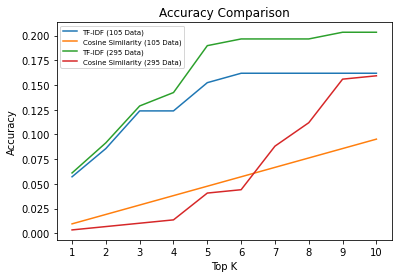

In [ ]:
df_acc.plot()
plt.ylabel('Accuracy')
plt.xlabel('Top K')
plt.legend(['TF-IDF (105 Data)',
            'Cosine Similarity (105 Data)',
            'TF-IDF (295 Data)',
            'Cosine Similarity (295 Data)'],
           loc=0,
           fontsize='x-small',
           )
plt.xticks(np.arange(1, 11, 1))
plt.title('Accuracy Comparison')
plt.show()